# How to use the COSIMA Cookbook

This tutorial is designed to help new users get to grips with the COSIMA Cookbook. The COSIMA Cookbook collection of recipes for analysing ocean and sea ice model output, using a common method of loading the output.

It assumes that:
 * You have access to the ACCESS-NRI Intake Catalog (through project `xp65`).
 * You can fire up a Jupyter notebook on NCI's ARE.
 * You can access an appropriate set of `conda` packages to load the appropriate python libraries.

**Before starting,** load in some standard libraries that you are likely to need:

In [1]:
import matplotlib.pyplot as plt
import cmocean as cm
import xarray as xr
import numpy as np

In addition, you **always** need to load the `intake` module. 
This provides functions that we use to load data via the ACCESS-NRI Intake Catalog:

In [2]:
import intake

## 1. The Cookbook Philosophy
The COSIMA Cookbook is a framework for analysing ocean-sea ice model output.
It is designed to:

* Provide examples of commonly used diagnostics;
* Write efficient, well-documented, openly accessible code;
* Encourage community input to the code;
* Ensure diagnostic results are reproducible;
* Process diagnostics directly from the model output, minimising creation of intermediate files;
* Find methods to deal with the memory limitations of analysing high-resolution model output.


### 1.1 A database of experiments
The COSIMA Cookbook relies on a database of experiments (let's call it a datastore) in order to load model output. This datastore effectively holds metadata for each experiment, as well as variable names, data ranges and so on. 

**NCI Projects**: Access to COSIMA ocean-sea ice model output requires that you are a member of NCI projects `xp65`, `hh5`, `ik11` and `cj50`.

With that sorted out, there are three different ways for you to access the datastore:

1. Use the default ACCESS-NRI catalog, which is periodically refreshed automatically. This datastore includes many experiments stored in the COSIMA data directories on NCI under the projects mentioned above. The examples in this tutorial use this datastore.

2. Use another datastore that someone has made for you.

3. Make your own catalog, which is stored in your own path and includes only the experiments you are interested in. Please refer to the `Make_Your_Own_Intake_Datastore` tutorial for instructions on how to create this datastore.

To access the default datastore, you need to load it each time you fire up a notebook:

In [3]:
catalog = intake.cat.access_nri

### 1.2 Inbuilt Catalog Functions

We have constructed a few functions to help you operate the cookbook and to access the datasets.  The following functions query and display the data available in the datastore, without loading the data itself.

`catalog` lists all of the experiments and variables that are included in the datastore. The format is mostly self-explanatory, but the list is huge (and noth particularly useful):

In [4]:
catalog

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{ocean, seaIce}","{3hr, 1mon, 1day, 3mon, fx}","{salt_global_ave, drag_coeff, lprec, alvdf_ai_m, sea_level, total_ocean_river, melt, flatn_ai_m, divu_m, total_ocean_heat, fsalt_ai_m, shear_m, total_ocean_fprec, aice_m, frazil_3d, strairy_m, bih..."
01deg_jra55v140_iaf,{ACCESS-OM2},{Cycle 1 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{ocean, seaIce}","{fx, 1day, 1mon}","{salt_global_ave, vorticity_z, drag_coeff, lprec, alvdf_ai_m, sea_level, total_ocean_river, melt, flatn_ai_m, divu_m, total_ocean_heat, fsalt_ai_m, shear_m, total_ocean_fprec, daidtt_m, vvel, aice..."
01deg_jra55v140_iaf_cycle2,{ACCESS-OM2},{Cycle 2 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{ocean, seaIce}","{fx, 1day, 1mon}","{salt_global_ave, drag_coeff, lprec, alvdf_ai_m, sea_level, total_ocean_river, fsurf_ai_m, melt, flatn_ai_m, divu_m, total_ocean_heat, fsalt_ai_m, shear_m, total_ocean_fprec, daidtt_m, vvel, aice_..."
01deg_jra55v140_iaf_cycle3,{ACCESS-OM2},{Cycle 3 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{ocean, seaIce}","{fx, 1day, 1mon}","{salt_global_ave, drag_coeff, lprec, alvdf_ai_m, sea_level, total_ocean_river, fsurf_ai_m, melt, flatn_ai_m, divu_m, total_ocean_heat, fsalt_ai_m, shear_m, total_ocean_fprec, daidtt_m, vvel, aice_..."
01deg_jra55v140_iaf_cycle4,{ACCESS-OM2},{Cycle 4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{ocean, seaIce}","{6hr, 3hr, 1mon, 1day, fx}","{drag_coeff, uvel_h, radbio_int100, fsurf_ai_m, melt, shear_m, time_bnds, aice_m, geolon_c, total_ocean_evap, no3, dardg2dt, ke_tot, total_ocean_runoff_heat, total_ocean_pme_river, surface_pot_tem..."
01deg_jra55v140_iaf_cycle4_jra55v150_extension,{ACCESS-OM2},{Extensions of cycle 4 of 0.1 degree ACCESS-OM2 + WOMBAT BGC global model configuration with JRA55-do v1.5.0 and v1.5.0.1 interannual forcing},"{ocean, seaIce}","{fx, subhr, 1day, 1mon}","{dic_zflux_adv, salt_global_ave, drag_coeff, o2_xflux_adv, skl_Nit, lprec, det_zflux_adv, alvdf_ai_m, sea_level, total_ocean_river, radbio_int100, surface_o2, dic_int100, melt, flatn_ai_m, divu_m,..."
01deg_jra55v150_iaf_cycle1,{ACCESS-OM2},{Cycle 1 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.5.0 OMIP2 interannual forcing},"{ocean, seaIce}","{fx, 1day, 1mon}","{drag_coeff, lprec, sea_level, melt, time_bnds, aice_m, ty_trans_rho, evap_heat, area_t, geolon_c, sea_level_sq, ULAT, tau_x, sfc_hflux_coupler, sfc_hflux_pme, surface_pot_temp, mld, sens_heat, ge..."
025deg_era5_iaf,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with ERA5 interannual\nforcing (1980-2021)},"{ocean, seaIce}","{fx, 1day, 1mon}","{salt_global_ave, temp_xflux_gm_int_z, drag_coeff, lprec, alvdf_ai_m, sea_level, total_ocean_river, strcorx_m, melt, flatn_ai_m, divu_m, total_ocean_heat, fsalt_ai_m, shear_m, total_ocean_fprec, d..."
025deg_era5_ryf,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with ERA5 RYF9091 repeat\nyear forcing (May 1990 to Apr 1991)},"{ocean, seaIce}","{fx, 1day, 1mon}","{salt_global_ave, temp_xflux_gm_int_z, drag_coeff, lprec, alvdf_ai_m, sea_level, total_ocean_river, strcorx_m, melt, flatn_ai_m, divu_m, total_ocean_heat, fsalt_ai_m, shear_m, total_ocean_fprec, d..."


Each line in the table above references a folder full of netCDF files with model output. **The COSIMA cookbook philosophy is that you don't need to know about the directories in which these files are stored to be able to interrogate them or to load the data**. 

However, with thousands of experiments in the datastore, the above table isn't so easy to understand. Luckily, you can refine your search to limit the runs you want to see. For example, if I already know the name of the experiment I want to see, I can specify that:

In [12]:
catalog.search(name='025deg_jra55_ryf9091_gadi')

,model,description,realm,frequency,variable
name,,,,,
025deg_jra55_ryf9091_gadi,{ACCESS-OM2},{0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{ocean, seaIce}","{fx, 1yr, 1mon}","{salt_global_ave, drag_coeff, alvdf_ai_m, sea_level, total_ocean_river, strcorx_m, divu_m, flatn_ai_m, fsalt_ai_m, total_ocean_heat, shear_m, total_ocean_fprec, daidtt_m, aice_m, strairy_m, albsni..."


This is more useful, because it focusses just on the experiment I'm interested in -- and provides a list of all the variables available that experiment. It also gives a short description which is a nice way to explore which experiments might be available.

Alternatively, you can search on other headers from the above table to find, for example, which experiments saved a particular variable, e.g. I could look for outputs with daily surface salt fields:

In [13]:
catalog.search(model="ACCESS-OM2", variable="surface_salt", frequency="1day")

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},{ocean},{1day},{surface_salt}
01deg_jra55v140_iaf,{ACCESS-OM2},{Cycle 1 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},{ocean},{1day},{surface_salt}
01deg_jra55v140_iaf_cycle2,{ACCESS-OM2},{Cycle 2 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},{ocean},{1day},{surface_salt}
01deg_jra55v140_iaf_cycle3,{ACCESS-OM2},{Cycle 3 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},{ocean},{1day},{surface_salt}
01deg_jra55v140_iaf_cycle4,{ACCESS-OM2},{Cycle 4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},{ocean},{1day},{surface_salt}
01deg_jra55v140_iaf_cycle4_jra55v150_extension,{ACCESS-OM2},{Extensions of cycle 4 of 0.1 degree ACCESS-OM2 + WOMBAT BGC global model configuration with JRA55-do v1.5.0 and v1.5.0.1 interannual forcing},{ocean},{1day},{surface_salt}
025deg_era5_iaf,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with ERA5 interannual\nforcing (1980-2021)},{ocean},{1day},{surface_salt}
025deg_era5_ryf,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with ERA5 RYF9091 repeat\nyear forcing (May 1990 to Apr 1991)},{ocean},{1day},{surface_salt}
025deg_jra55_iaf_era5comparison,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with JRA55-do v1.5.0\ninterannual forcing (1980-2019)},{ocean},{1day},{surface_salt}


### 1.3 Loading data from an experiment

Python has many ways of reading in data from a netcdf file ... so we thought we would add another way. This is done via the `.to_dask()` function, which is the most commonly used function in the cookbook. This function takes the output from a `catalog.search()` query to find a specific variable, and loads the files you need to create that variable.

Let's take now a little while to get to know this function. In it's simplest form, you need just three arguments: `experiment`, `variable`, and (in most cases) the `frequency` of the variable. 


In [25]:
experiment = '025deg_jra55_ryf9091_gadi'
variable = 'temp_global_ave'
ds = catalog[experiment].search(variable=variable).to_dask()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/coding/times.py:1005: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/coding/times.py:1005: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/coding/times.py:1005: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf

This command returns an `xarray` dataset, `ds` which contains the metadata of the variable, but not the variable itself. (Note that it's also possible to load several variables at once in this fashion).

You may find it easier to work with an `xarray` dataarray, in which case this can be extracted from the dataset as follows:

In [24]:
ds['temp_global_ave']

<xarray.DataArray 'temp_global_ave' (time: 7800, scalar_axis: 1)> Size: 62kB
dask.array<concatenate, shape=(7800, 1), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * scalar_axis  (scalar_axis) float64 8B 0.0
  * time         (time) object 62kB 1900-01-16 12:00:00 ... 2549-12-16 12:00:00
Attributes:
    long_name:      Global mean temp in liquid seawater
    units:          deg_C
    valid_range:    [ -10. 1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

You can see that this operation has loaded the globally averaged potential temperature  from the model output. The time axis runs from year 1900 to year 2459. For some variables (particularly 3D variables that might use a lot of memory) you may prefer to restrict yourself to a smaller time window:

In [28]:
ds['temp_global_ave'].sel(time=slice('2000-01-01','2050-12-31'))

<xarray.DataArray 'temp_global_ave' (time: 612, scalar_axis: 1)> Size: 5kB
dask.array<getitem, shape=(612, 1), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * scalar_axis  (scalar_axis) float64 8B 0.0
  * time         (time) object 5kB 2000-01-16 12:00:00 ... 2050-12-16 12:00:00
Attributes:
    long_name:      Global mean temp in liquid seawater
    units:          deg_C
    valid_range:    [ -10. 1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

### 1.4 Exercises
OK, this is a tutorial, so now you have to do some work. Your tasks are to:
* Find and load sea-surface height (ssh) from an experiment (perhaps choose a 1° configuration for starters).

* Load potential temperature from an experiment (again, 1° would be quickest). Can you chunk the data differently from the default?

## 2. How to manipulate and plot variables with xarray
We use the python package `xarray` (which is built on `dask`, `pandas`, `matplotlib` and `numpy`) for many of our diagnostics. `xarray` has a a lot of nice features, some of which we will try to demonstrate for you. 

### 2.1 Plotting
`xarray`'s `.plot()` method does its best to figure out what you are trying to plot, and plotting it for you. Let's start by loading a 1-dimensional variable and plotting.

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/coding/times.py:1005: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/coding/times.py:1005: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/coding/times.py:1005: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf

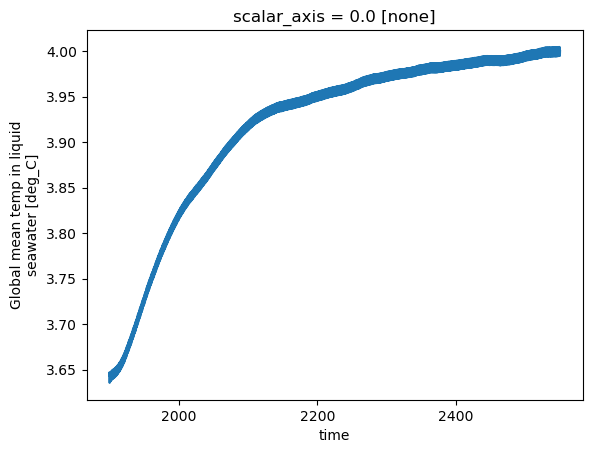

In [29]:
experiment = '025deg_jra55_ryf9091_gadi'
variable = 'temp_global_ave'
ds = catalog[experiment].search(variable=variable).to_dask()
ds[variable].plot()

You should see that `xarray` has figured out that this data is a timeseries, that the x-axis is representing time and that the y-axis is `temp_global_ave`. You can always modify aspects of your plot if you are unhappy with the default xarray behaviour:

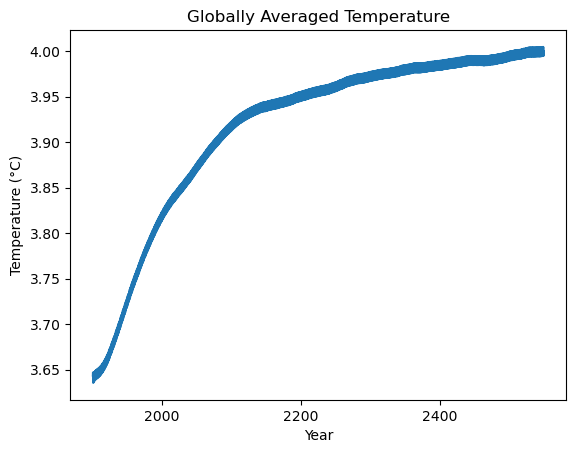

In [30]:
ds[variable].plot()
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Globally Averaged Temperature');

Because `xarray` knows about dimensions, it has plotting routines which can figure out what it should plot. By way of example, let's load a single time slice of `surface_temp` and see how `.plot()` handles it: 

In [39]:
experiment = '025deg_jra55_ryf9091_gadi'
variable = 'surface_temp'
ds = catalog.search(name=experiment,variable='temp')
#.to_dask()
#ds[variable].isel(time=-1).plot()
ds

,model,description,realm,frequency,variable
name,,,,,
025deg_jra55_ryf9091_gadi,{ACCESS-OM2},{0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},{ocean},"{1yr, 1mon}",{temp}


Again, you can customise this plot as you see fit:

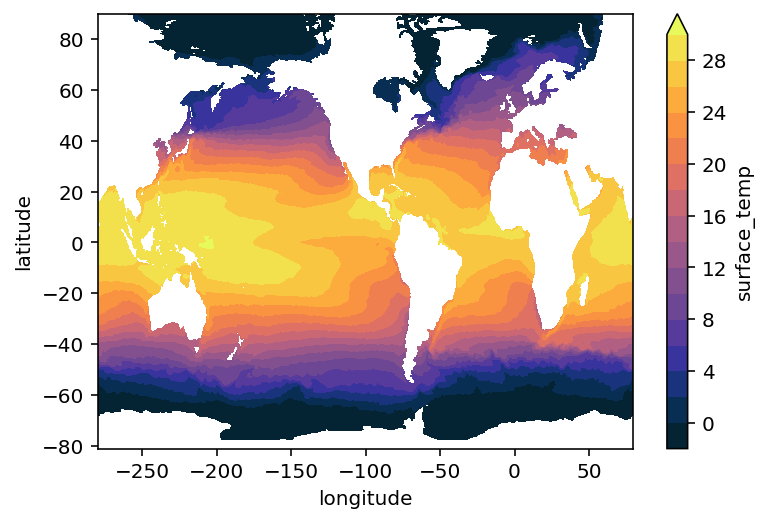

In [16]:
temp_C = darray - 273.15 # convert from Kelvin to Celsius
temp_C.mean('time').plot.contourf(levels=np.arange(-2, 32, 2), cmap=cm.cm.thermal);
plt.ylabel('latitude')
plt.xlabel('longitude');

### 2.2 Slicing and dicing

There are two different ways of subselecting from a DataArray: `isel` and `sel`. The first of these is probably what you are used to -- you specify the value of the index of the array. In the second case you specify the value of the coordinate you want to select. These two methods are demonstrated in the following example:

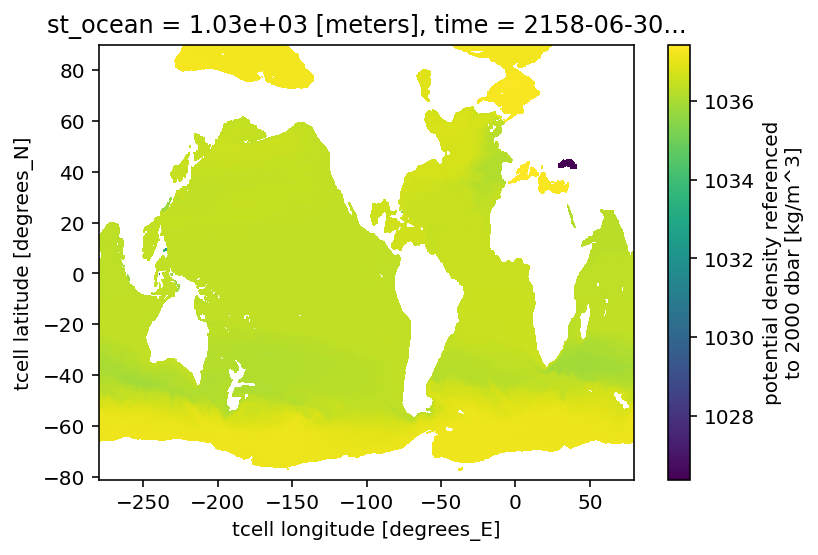

In [17]:
darray = cc.querying.getvar('025deg_jra55v13_iaf_gmredi6', 'pot_rho_2', session)
density = darray.isel(time = 200).sel(st_ocean = 1000, method='nearest')
density.plot();

In the above example, a 300-year dataset is loaded. We then use `isel` to select the 201st year (time index of 200) and use `sel` to select the $z$ level that is about 1000m deep. The `sel` method is very flexible, allowing us to use similar code in differing model resolutions or grids. In addition, both methods allow you to slice a range of values:

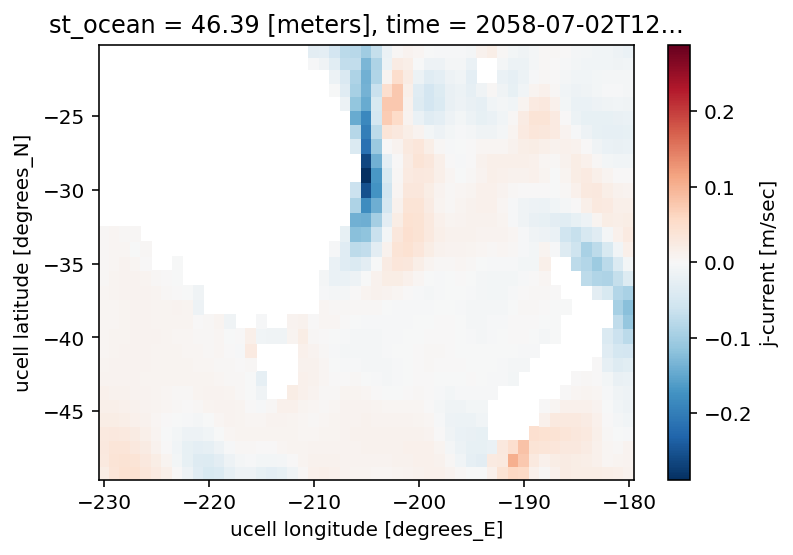

In [18]:
darray = cc.querying.getvar('1deg_jra55v13_iaf_spinup1_B1', 'v', session, ncfile="ocean.nc")
v = darray.isel(time = 100).sel(st_ocean=50, method='nearest').sel({'xu_ocean': slice(-230, -180),
                                                                    'yu_ocean': slice(-50, -20)})
v.plot();

Here we have taken meridional velocity, and sliced out a small region of interest for our plot.

### 2.3 Averaging along dimensions

We often perform operations such as averaging on dataarrays. Again, knowledge of the coordinates can be a big help here, as you can instruct the `mean()` method to operate along given coordinates. The case below takes a temporal and zonal average of potential density.

#### IMPORTANT
To be precise, it is actually a mean in the $i$-grid direction, which is only zonal outside the tripolar region in the Arctic, i.e., *south of 65N* in the ACCESS-OM2 models. To compute the zonal mean correctly one needs to be a bit more carefull; see the [`Examples/True_Zonal_Mean.ipynb`](https://cosima-recipes.readthedocs.io/en/latest/examples/True_Zonal_Mean.html#gallery-examples-true-zonal-mean-ipynb).

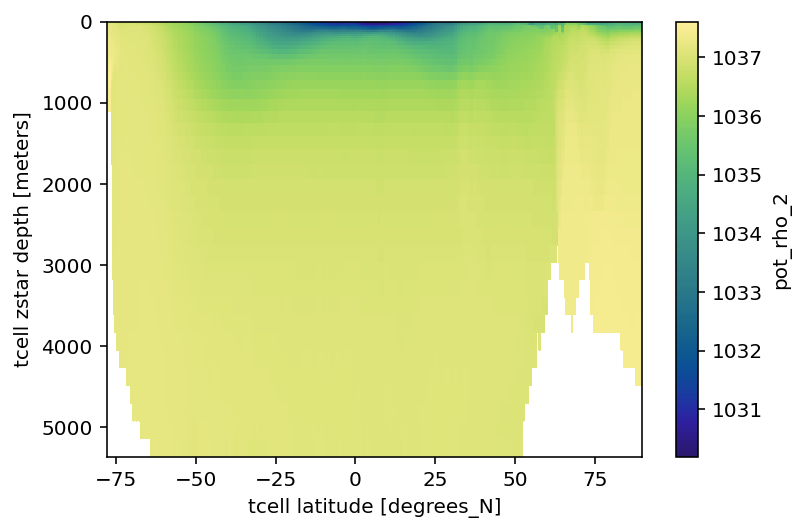

In [19]:
darray = cc.querying.getvar('1deg_jra55v13_iaf_spinup1_B1', 'pot_rho_2', session, n=-10)
darray.mean({'time', 'xt_ocean'}).plot(cmap=cm.cm.haline)
plt.gca().invert_yaxis();

### 2.4 Resampling

`xarray` uses `datetime` conventions to allow for operations such as resampling in time. This resampling is simple and powerful. Here is an example of re-plotting the figure from 2.1 with annual averaging:

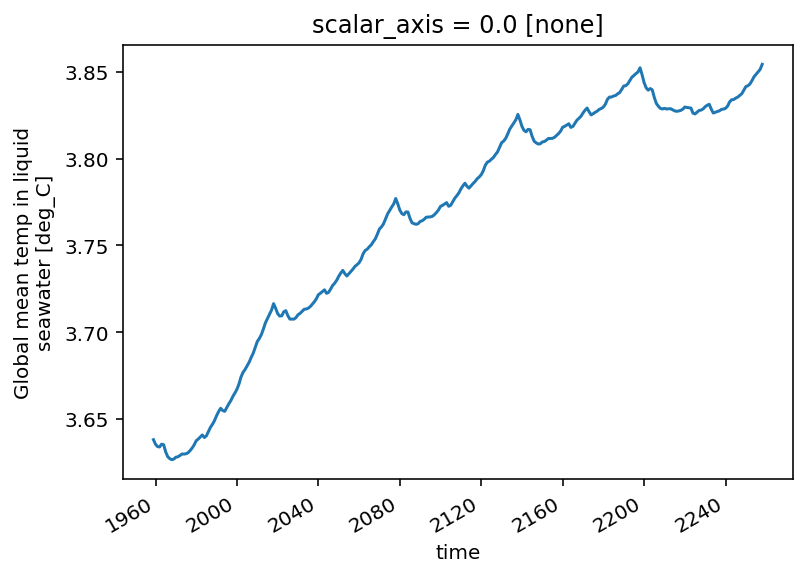

In [20]:
darray = cc.querying.getvar('025deg_jra55v13_iaf_gmredi6', 'temp_global_ave', session)
meandata = darray.resample(time='A').mean(dim='time')
meandata.plot();

### 2.5 Exercises

 * Pick an experiment and plot a map of the temperature of the upper 100m of the ocean for one year.

 * Now, take the same experiment and construct a timeseries of spatially averaged (regional or global) upper 700m temperature, resampled every 3 years.

## 3. More Advanced Stuff

### 3.1 Making a map with cartopy
Refer to [map tutorial](https://cosima-recipes.readthedocs.io/en/latest/tutorials/Making_Maps_with_Cartopy.html#gallery-tutorials-making-maps-with-cartopy-ipynb).

### 3.2 Distributed computing

Many of our scripts use multiple cores for their calculations, usually via the following . It sets up a local cluster on your node for distributed computation. 

In [21]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42889,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:44119,Total threads: 3
Dashboard: /proxy/44067/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:32781,


The dashboard link should allow you to access information on how your work is distributed between the cores on your local cluster.